# Final report

## First stage - classic ML tools

We prepared the data from old contests, each entry consists of:
* User
* Contest ID
* Start of the contest (day and hour)
* Duration of the contest
* Rating before contest
* Rating change during the contest
* Correlation between this user and the author (defined by old contests that they have written together)

As always, we divided the dataset into two parts - training data, and test data. We used training data to train our decision tree/random forest/boosting, and later tested it with test data.


### Decision trees, Random forests

Unfortunately, we met several challenges. The most problematic was the enormous number of entries. These structures weren't able to handle this amount of data (even few thousands entries took forever to prepare the model), so we couldn't train our model on whole training dataset. Because the results on small chunks of data, weren't too promising, we couldn't find out the correct parameters for our structures.
The other challenge was the fact that the data for codeforces isn't perfect. For example, many authors were missing for contests, often people doesn't share their nationality, so we couldn't use many features that could possibly influence the result.

We decided to remove some features and focus on the most important ones. Then it turned out, that most of them has zero correlation with the predicted result (either rank or rating). That's why we decided to acknowledge this approach as failed, and try different ones.

### KNN

When it comes to KNN, it could not find any relation between the data, so its accuraccy was $\approx 50\%$ (when predicting if rating would increase, decrease or stay the same). We have tried different distance measures to calculate distances - e.g. uniform weights, weights inversely proportional to distance, custom weights for particular features. It did not provide any results.

### Boosting

We have tried to non-linearly transform the data - calculate scalar products between features, exponetiate them, ... . We have also tried to incorporate correlation measure between user and contest author (nationality, their performances). Unfortunately none of these methods provided any satisfactory results.

### Regressions

The results were not satisfying (tried different data manipulations and approaches - dividing participants into sets and interfer results from sets, predicting results using only individual participant history results, predicting the rank change (binary and numerically)

### Neural networks

Just as the other approaches we didn't manage to create a neural network which would correctly predict rating change/ranking. When we gave a small input for any NN it seemed it couldn't find any regularitise but when we 'fed' it with almost everything we could a single epoch loop took around 4 hours. We've tried using just some subset of data but the NN still couldn't learn anything on it.

## Second stage - rating systems

### Elo rating system

#### Basics

Elo rating is prepared for duels between two players. It is a basic rating system, which keeps only the user rating. 

We tested it in two ways:
- Treating each contest for a player as a duel
- Treating each participant in a contest as a duel partner

The first option did not gave any satisfactory results, this is why we focused on the second model.

The second option for one player calculated summed up rating change between other participants and changed the rating after the contest.

The model have three hyperparameters which seems independent:
- BasicRating - rating with which the user starts
- K - value which parameterize the rating change
- EloConst1 - value which parameterize the probability of winning with oponnent

#### Results

We tried to optimize the error between the predicted contest place and the real one.

Errors for the basic model (BaseRating = 1200, k = 1, EloConst1 = 400)

sqrt_err: 18.873759321330645 mean +- 4.774499376749239 stdev


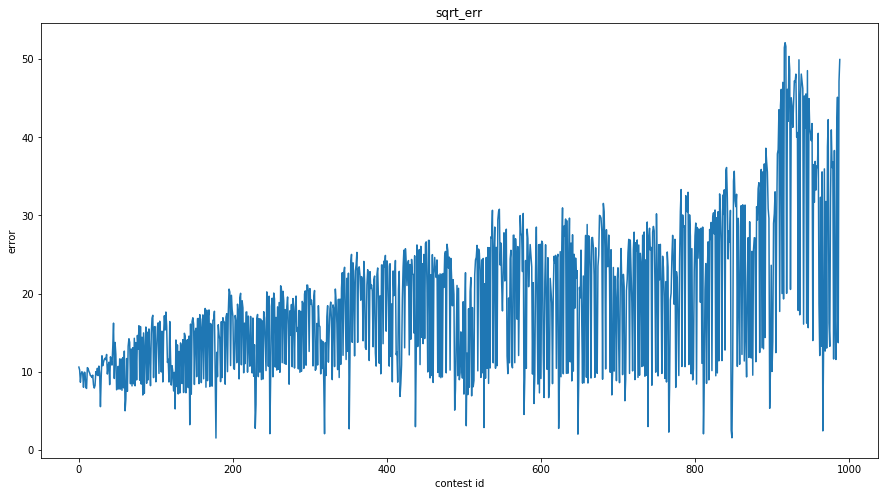

linear_err: 540.482170786376 mean +- 275.79070617469995 stdev


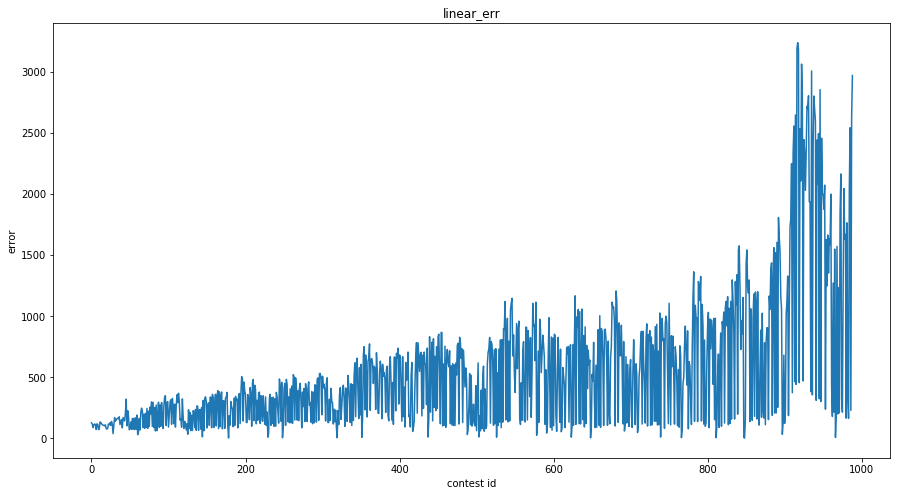

log_err: 0.6431339016089408 mean +- 0.04683847378956822 stdev


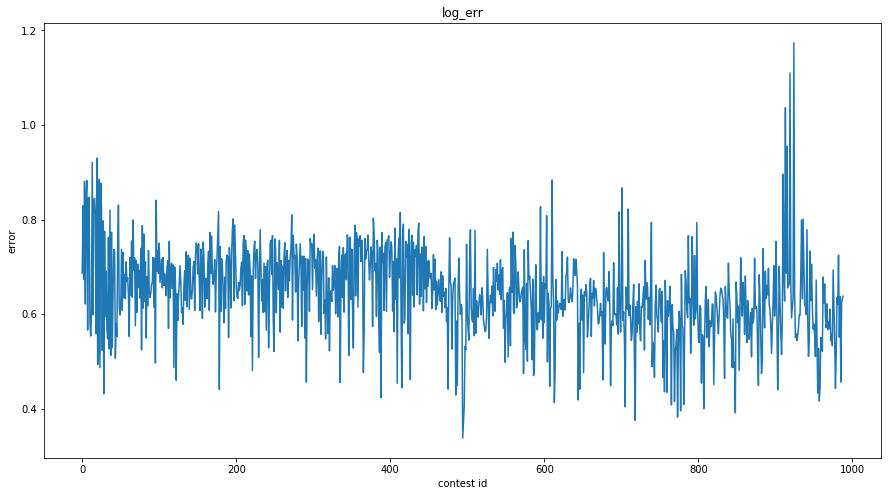

We will focused on the logarithmic error, cause the another one are dependent on the numbers of participants (which are increasing through contests)

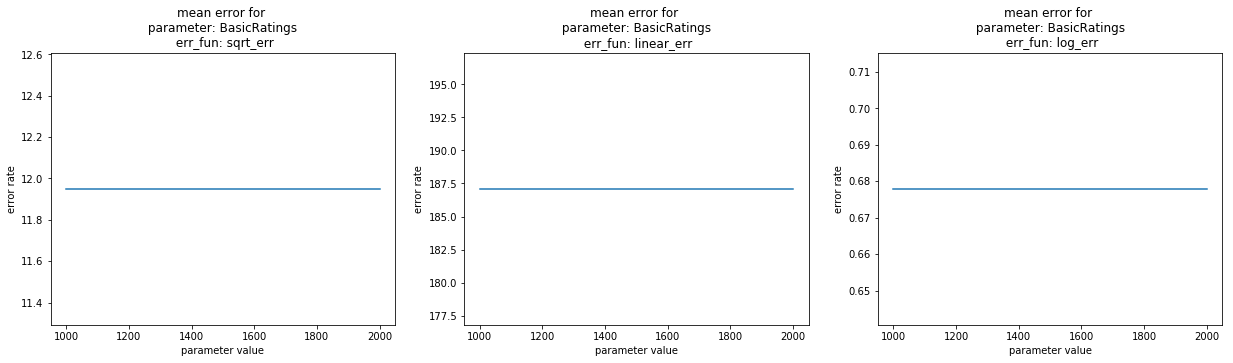

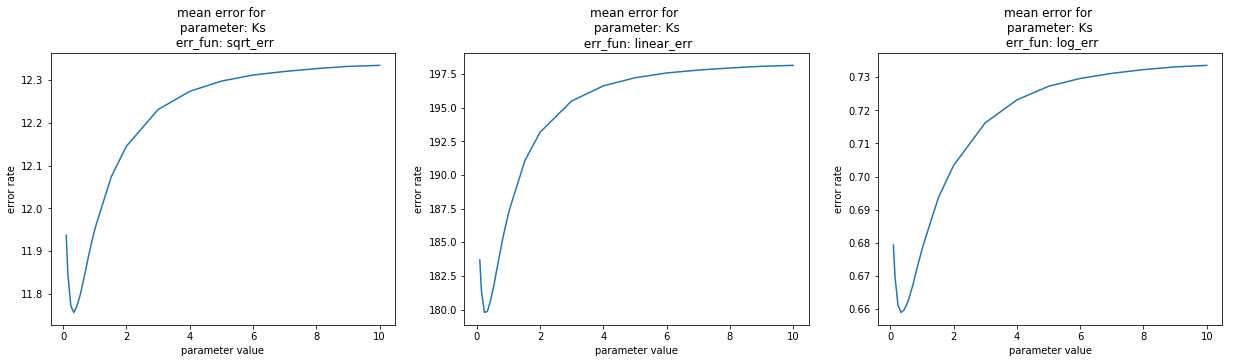

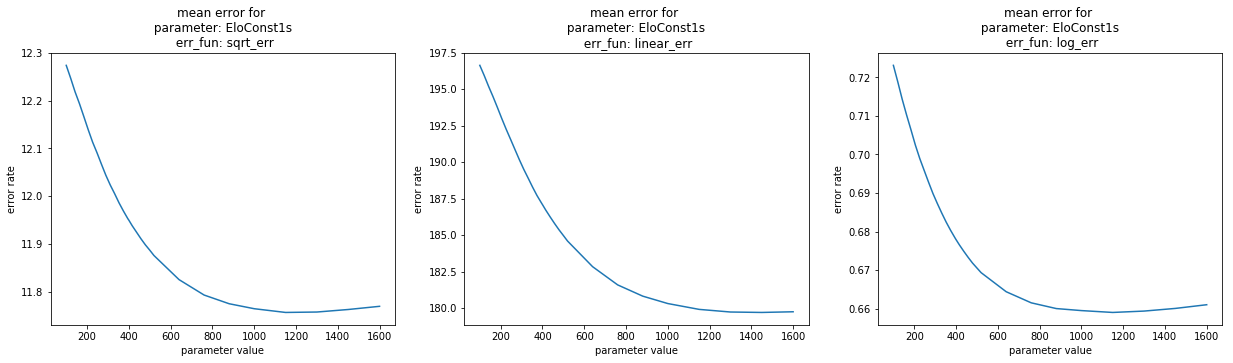

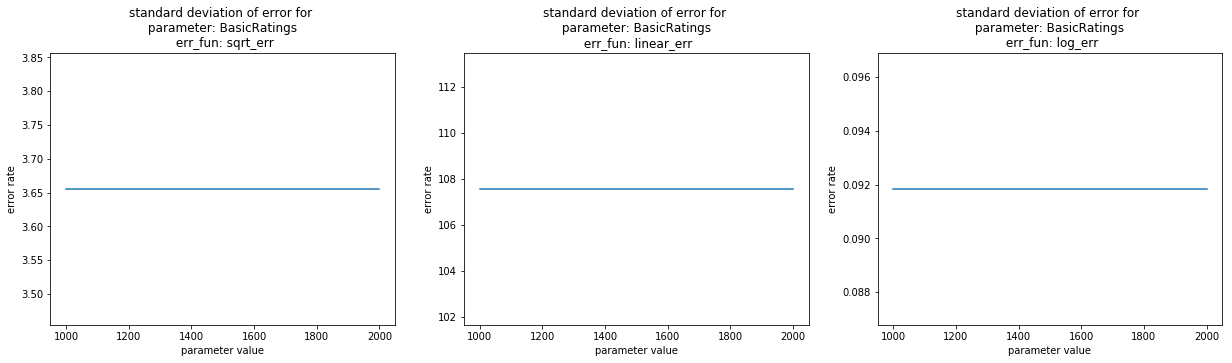

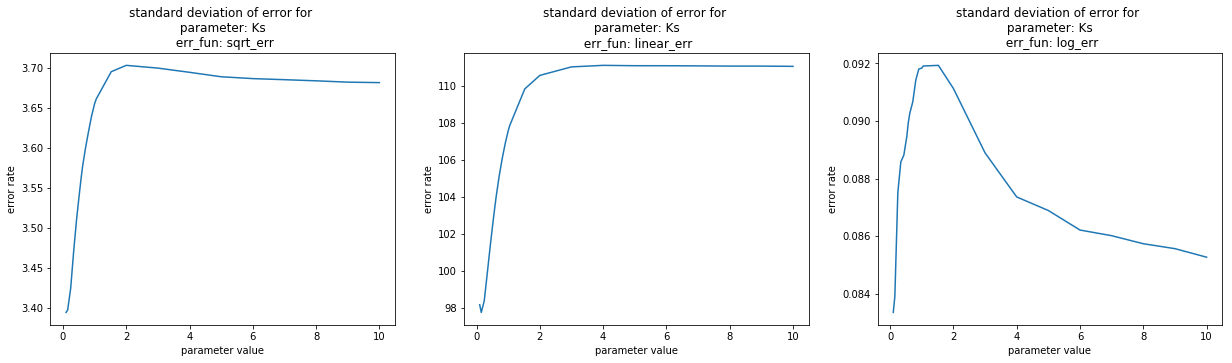

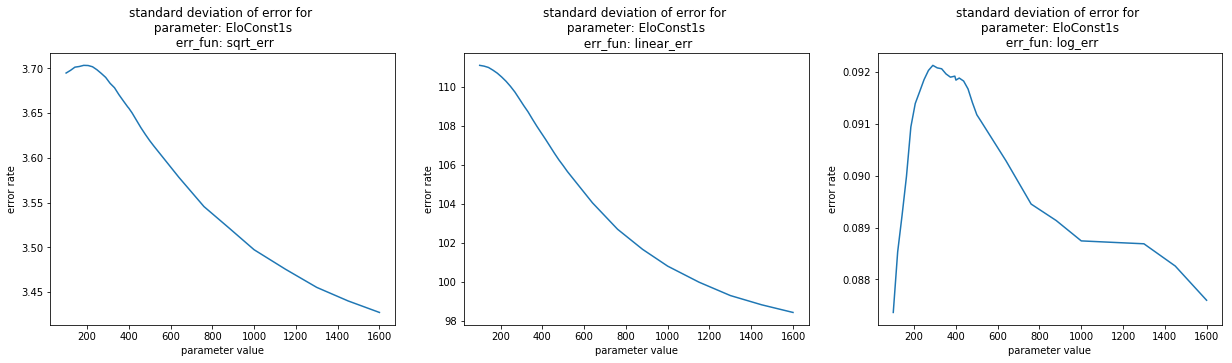

From the results we can interfer that the BasicRating does not influence our model. We tried to find the optimal value for k and EloConst1.

Searching for the optimal value of k.

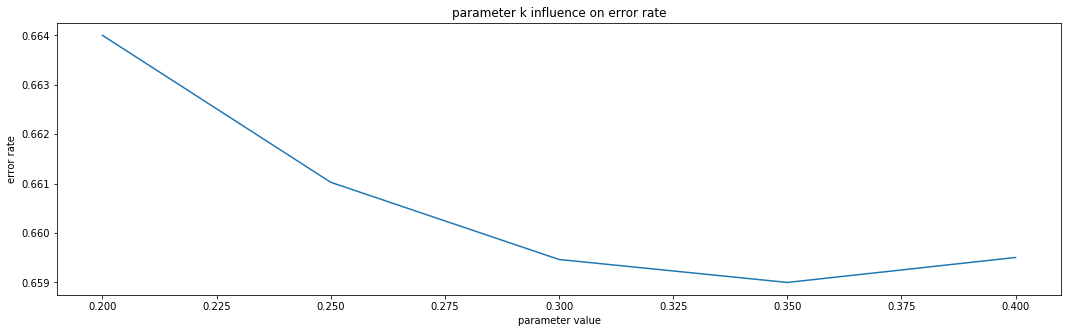

The optimal value found for k is 0.35

Now knowing the optimal k we tried to find the EloConst1, but the errors changed for the optimal k -> EloConst1 depends on k.

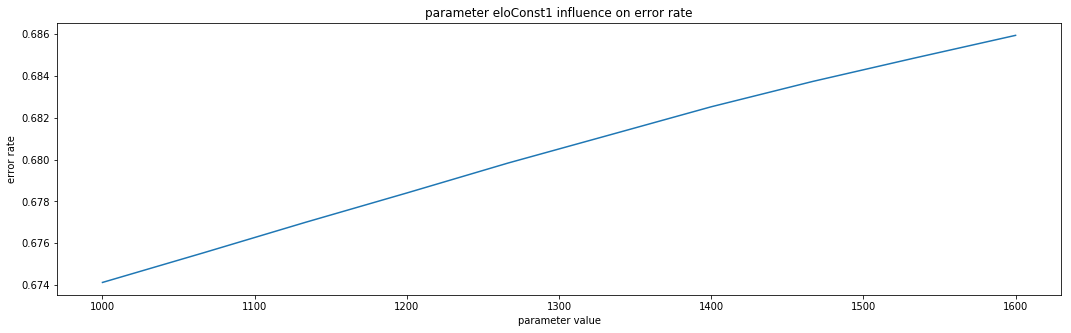

We change the range we checked before.

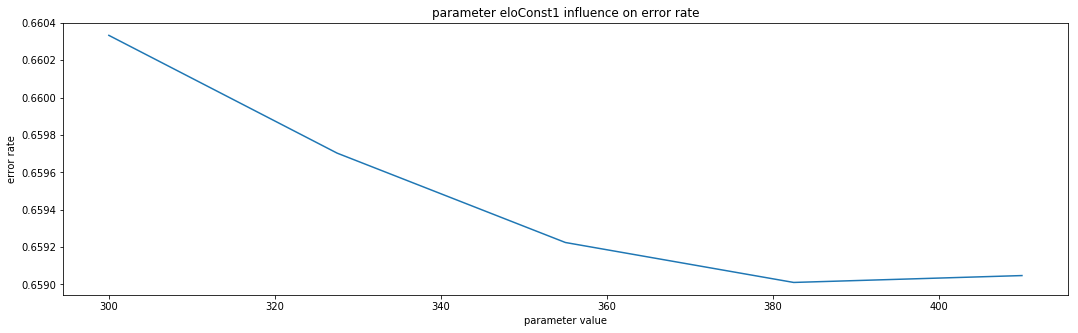

The optimal value of EloConst1 for k = 0.35 is 382.5

The logarithmic error for the optimal parameter is ...

### Topcoder rating system

#### Basics

Topcoder rating for each user keeps two values:
* Rating describing user's strength
* Volatility describing how likely is user's rating to change

After each contest, the rating and volatility are updated. Updates depend on:
* User's performance in the contest
* Number of contests written by the user
    * Users with fewer contests are more likely to have a higher rating change
* User's rating
    * Users with a higher rating are less likely to have larger rating change

The exact formulas are described [here](https://www.topcoder.com/community/competitive-programming/how-to-compete/ratings), thus we elude repeating them.

In the solution, we parametrized constants in the mentioned formulas in order to obtain better results.

#### Results

We start with presenting the comparison between Codeforces and Topcoder rating systems for selected users. We can observe that Topcoder's rating system prefers larger differences than Codeforces, i.e., high rated users have higher ratings, and low rated users have lower ratings.

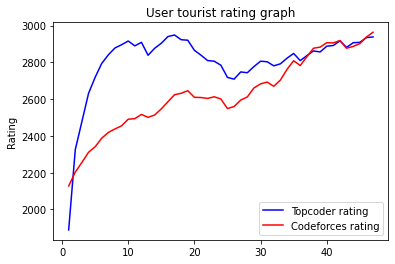

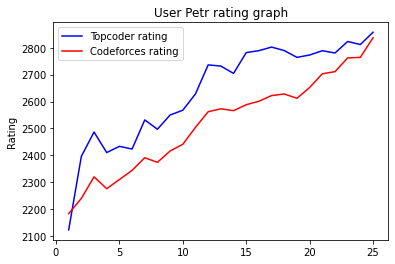

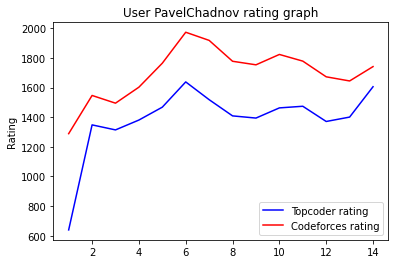

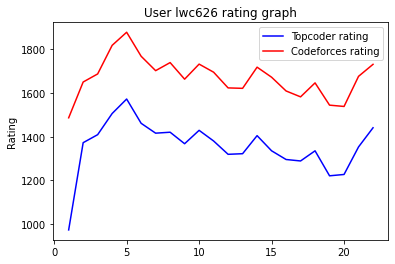

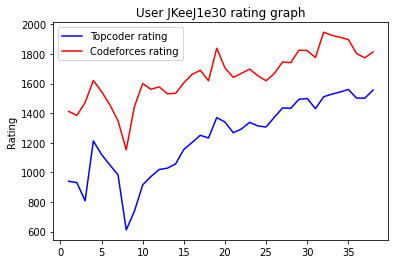

Here we present the comparison of predicted place by rating system (red line), and actual place (blue line). We see that the main problem with any prediction is the huge variation of the user's performance in the contest due to many unpredictable random events.

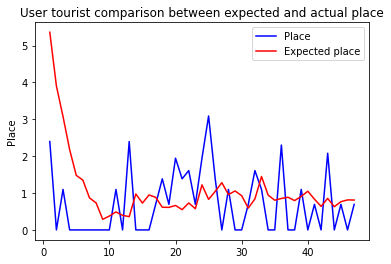

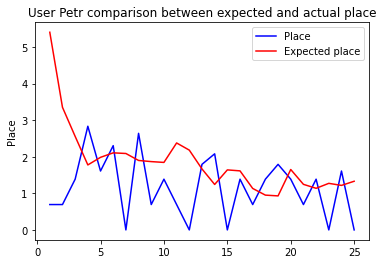

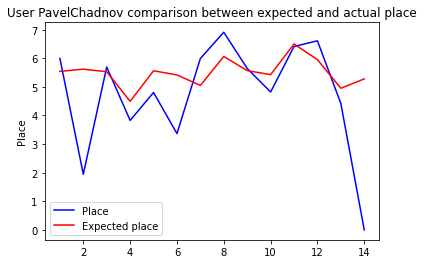

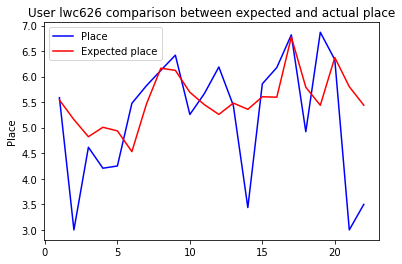

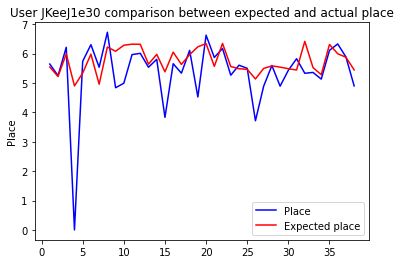

Finally, we move to the graph showing the average errors made by predictor. The regression line shows the trend, that the errors decrease in time. The reason is that we are able to gather more information about the user.

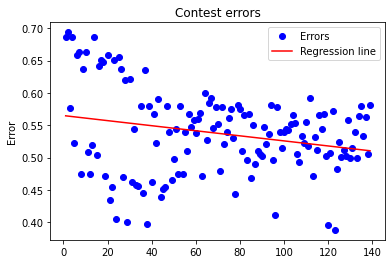

### Atcoder rating system

#### Basics

AtCoder rating is a rating system which keeps track of the average performance of each user with more weight on recent contests, and stronger response for good performances than bad ones.

AtCoder rating system depends on Logistic Distribution (Sigmoid Function).
In each contest, we calculate performance of each participant based on:
* his/her place in final ranking
* other participants ratings

Then rating is calculated (simply speaking) as a weighted mean of performances.

The exact formulas are described [here](https://www.dropbox.com/sh/zpgcogxmmu84rr8/AADcw6o7M9tJFDgtpqEQQ46Ua?dl=0&preview=rating.pdf).

#### Results

##### Rating shape examples

Below we present comparison of CodeForces rating and AtCoder based ratings for individual users.

45 45
number of contests 45


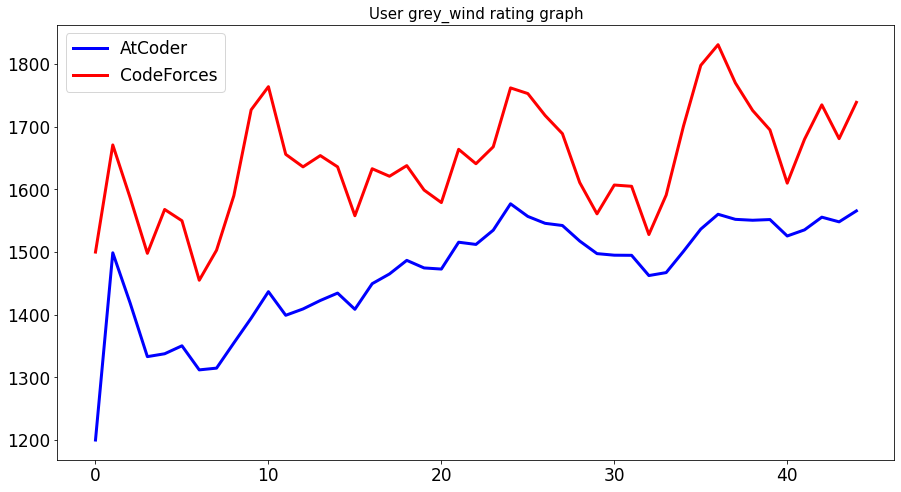

56 56
number of contests 56


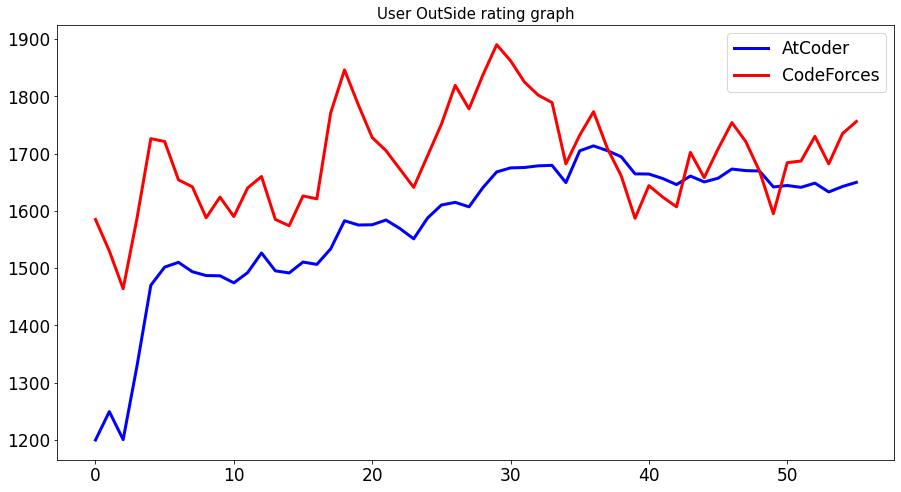

We can see that AtCoder rating (at least in default setup) is much more moderate than CodeForces whose plot is much more spiky.

##### Influence of different parameters on rating shape.

Below we can see influence of different parameters of the system on the shape of the individual user rating.

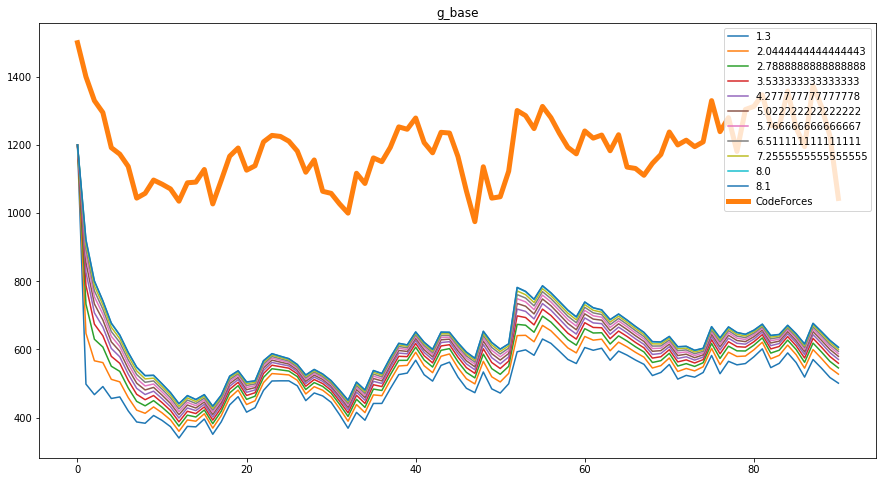

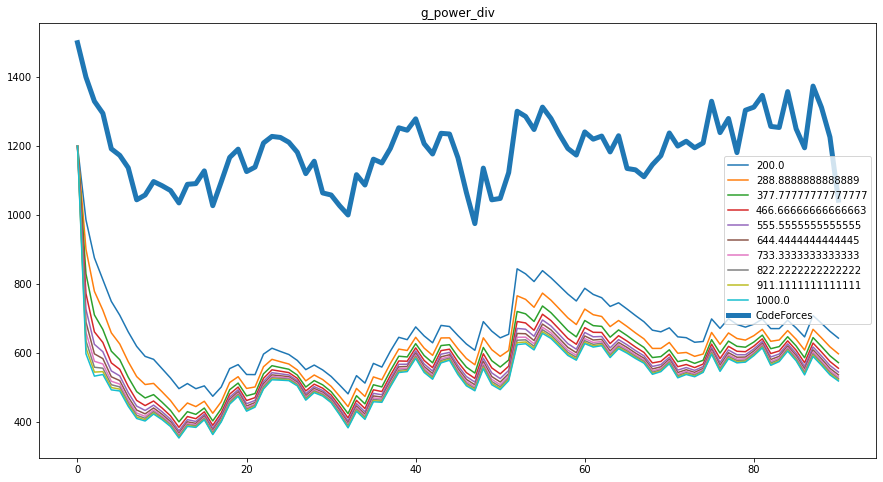

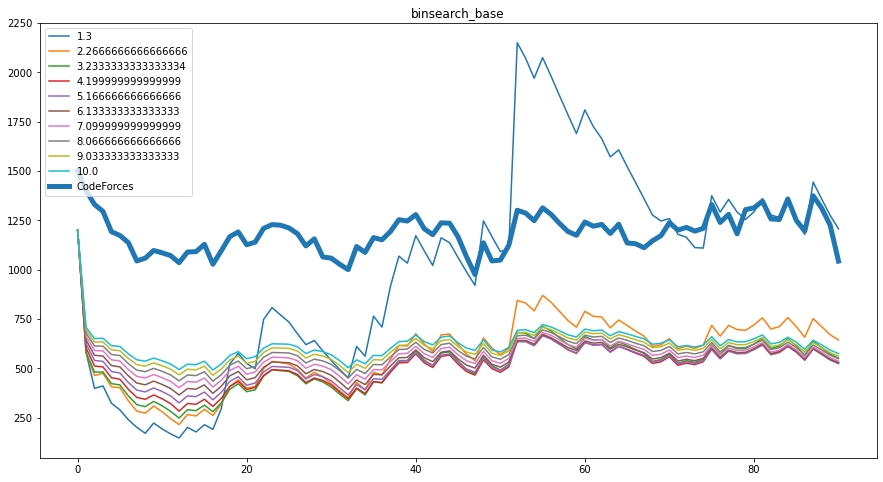

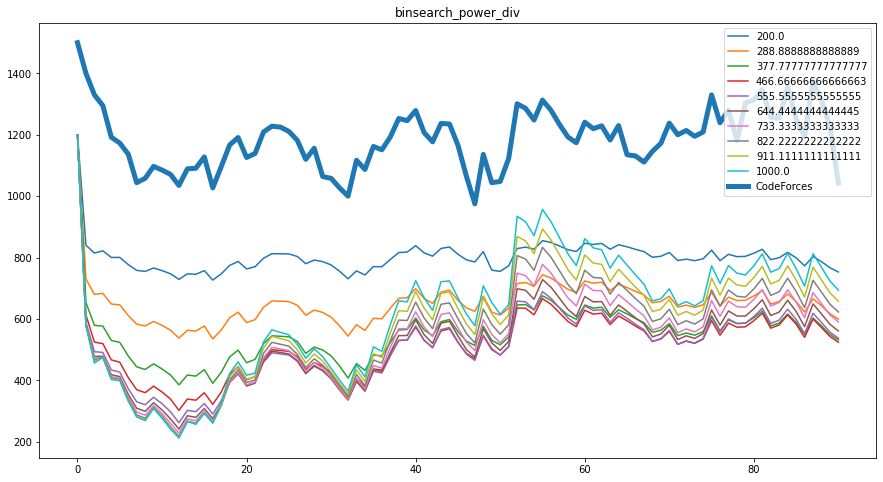

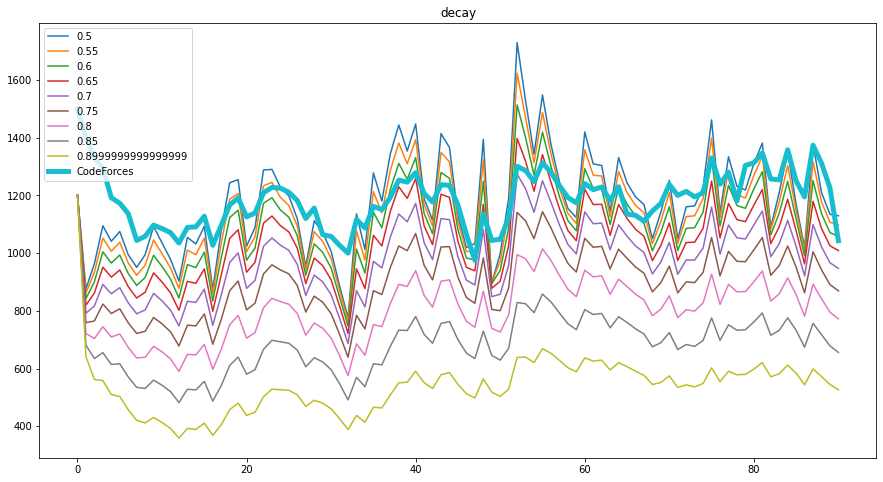

We can see that the biggest difference makes `decay` parameter which is responsible for weighted average sum of recent user's performances in previous contests. Average performance of user is (simply speaking) $$decay^i * performance_i.$$ We can notice that the smaller the `decay`, the more dramatic are the changes after each contest. That was also the parameter that influenced error rate the most. Interesting thing is that it was set to $0.9$ by default, while its optimal value was found to be around $0.71$, so it was pretty noticeable change.

##### Influence of different type of parameters on different error types

Here we can see parameter influence on error rate. Analysis below is one-dimensional - we do not consider co-dependecies of parameters, but actual optimal parameter search space was done in more jointly-parameter-regagarding manner. 

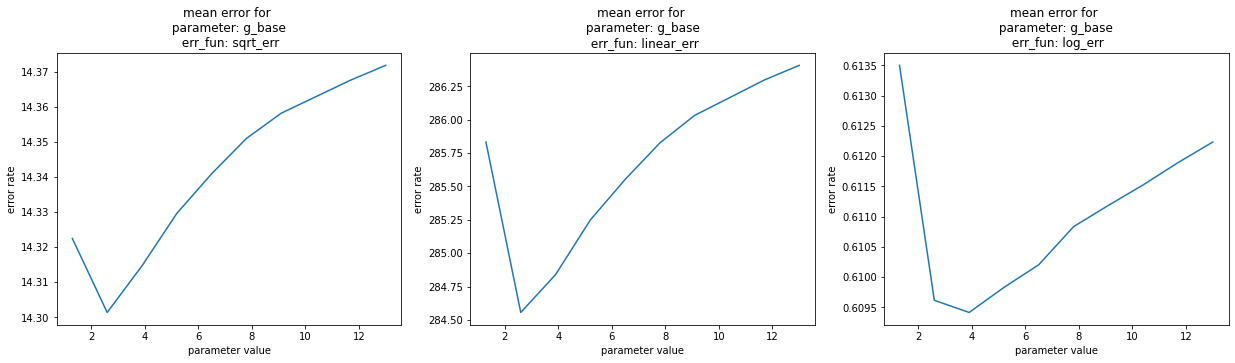

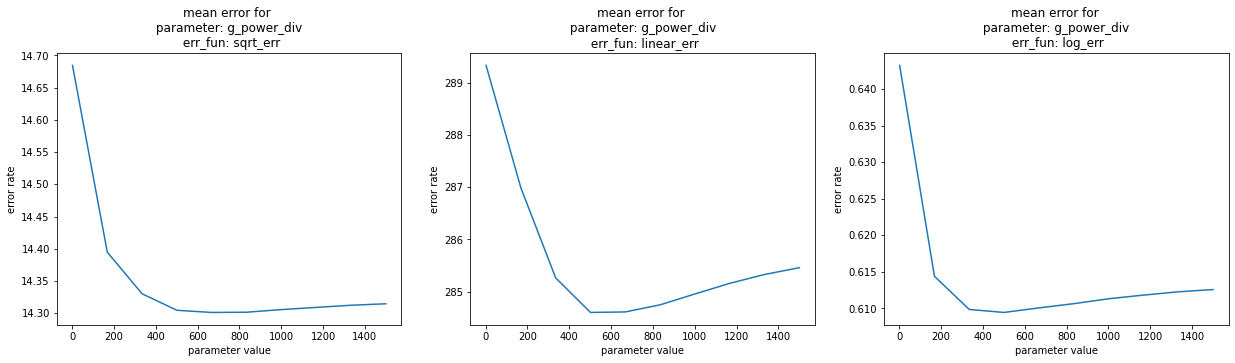

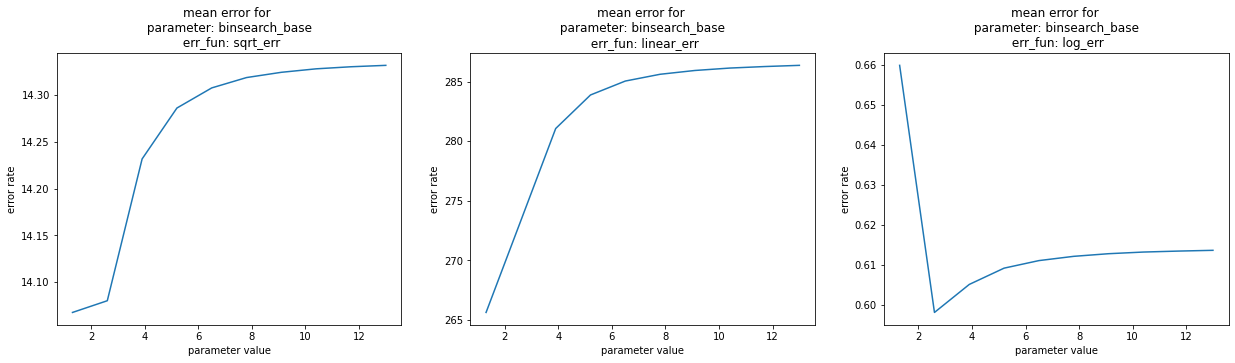

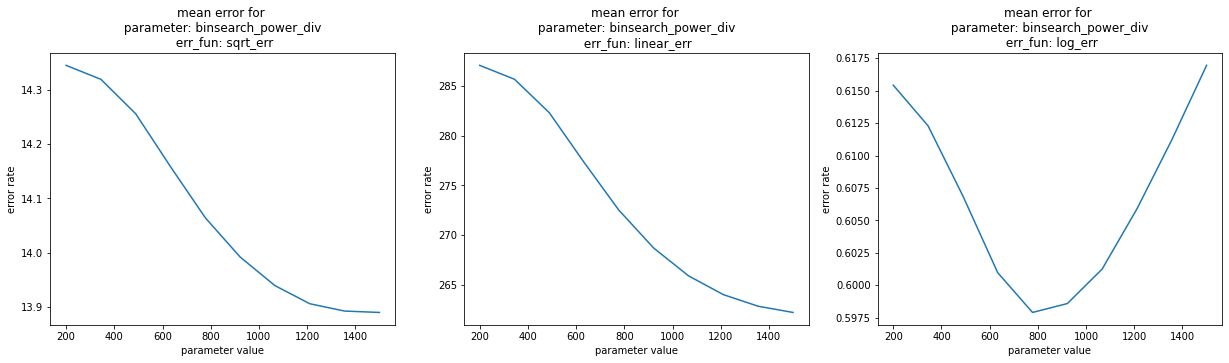

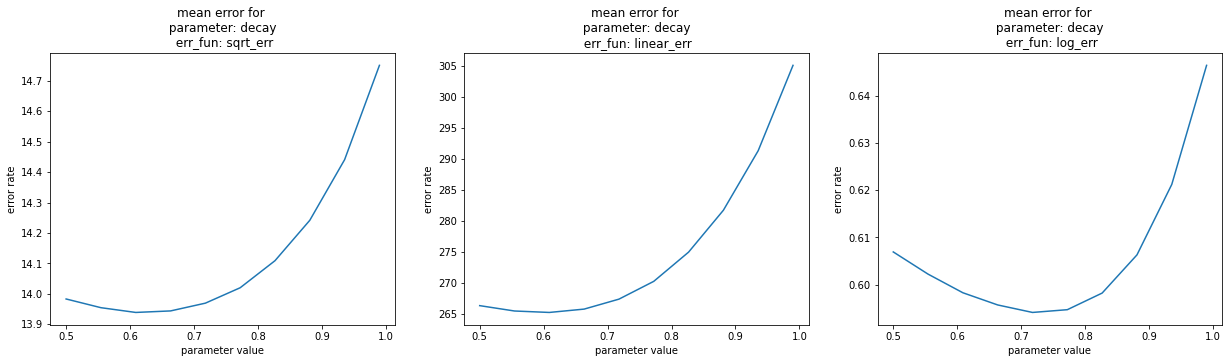

As we can see for every individual parameter we have something like global minimum point, so optimization of rating calculation is possible, which was conducted and optimal parameters were found.

### Codeforces rating system

#### Basics

Codeforce's rank prediction system is based on probability formula which states that contestant A is going to be better than B. This formula is solely based on some hyperparameters and rating values. Since it's quite similar to the formula used in ELO rating we've decided to pursue other ideas than adjusting the hyperparameters. 

Since Codeforce's predicted place is a sum over probability of contestants being better we've figured that if we could perfectly predict that contestant A is better than B the rank will be perfectly predicted as well. (**Note** this is a similar approach to the first one but instead of predicting ranking/rating change we're just trying to predict if one contestant is better than other - which seems a bit easier). We've decided to try neural networks for that.

- There were many iterations of our nets (different number of hidden layers, activation functions, loss functions and optimizers). 

- We've tried adding other parameters than just rating to our input vectors. Such as time elapsed from previous contest or votality/momentum of contestant's rating. 

#### Results

Unfortunetly none of our models succeed. We always ended up predicting the mean value of expected outputs rather than the actual outputs. 

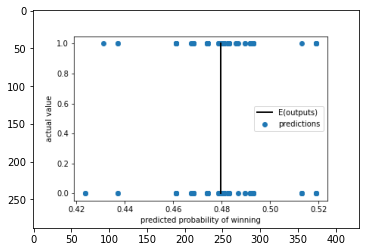

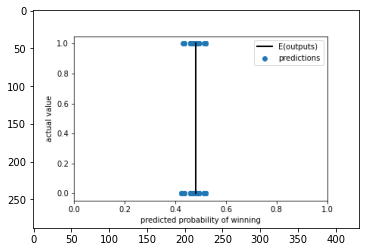

# Conclusions (TODO)